# Trendvorhersage

Die Vorhersage von Trends ist aus unterschiedlichen Gründen sehr interessant und wird schon seit sehr, sehr langer Zeit analysiert. 

Dafür kommen sowohl statistische Methoden als auch (modernere) Methoden des Maschinellen Lernens in Frage. Wir werden uns in diesem Teil beides anschauen und sowohl Trends in den Metadaten als auch in den Textbeiträgen selbst analysieren.

Wir beginnen mit einer Einführung und den Metadaten-Trends.

## Beispiel: Berechnung der Handy-Laufzeit

Wo wird das benötigt?

Eigentlich überall, nicht nur bei Corona-Zahlen, sondern auch in deinem Handy, wenn du wissen möchtest, wie lange der Akku noch hält.

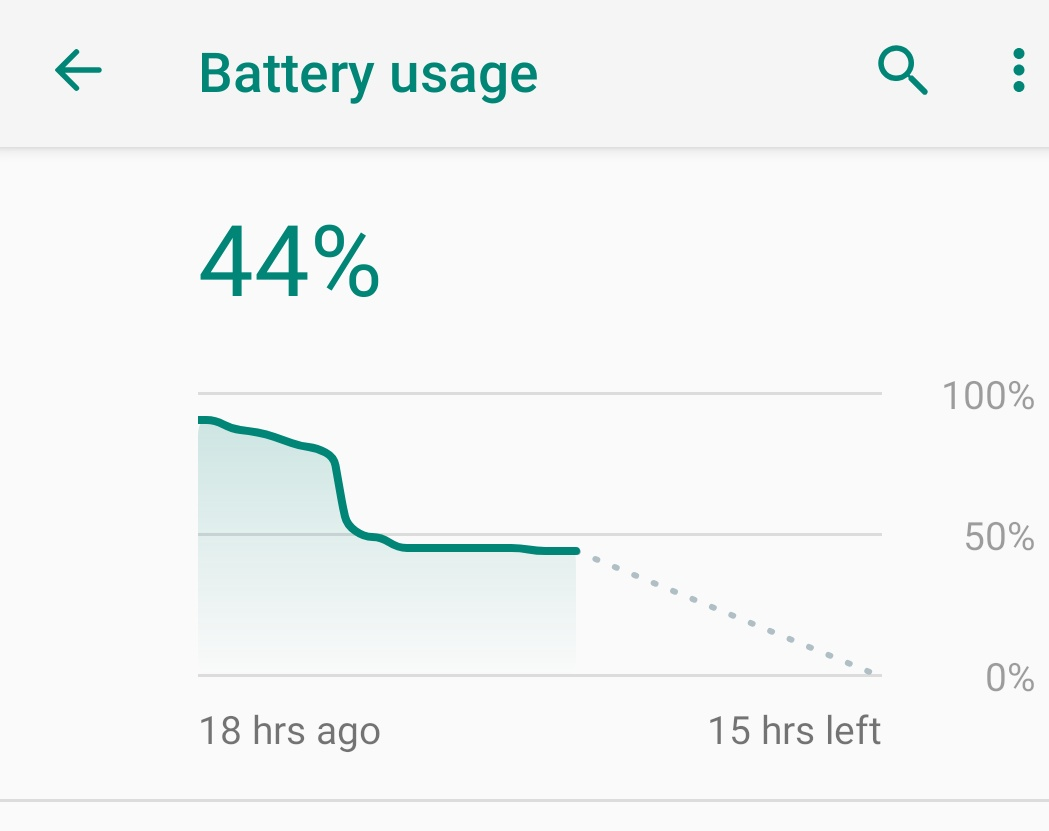

## Zeitreihen und lineare Regression

Trendvorhersagen benötigen [Zeitreihen](https://de.wikipedia.org/wiki/Zeitreihenanalyse). Im einfachsten Fall nutzt mal zur Vorhersage die sog. [Lineare Regression](https://de.wikipedia.org/wiki/Lineare_Regression).

In dem Fall des Bildes oben sind die Messwerte der Zeitreihe die jeweiligen Füllstände des Akkus. Die Regressionsgerade versucht, die Messwerte bestmöglich zu approximieren und sagt dann voraus, wann der Akku leer sein wird. Das ist natürlich eine grobe Näherung, aber immerhin eine Prognose.

Betrachten wir dazu ein Beispiel und versuchen, die Batteriekurve von oben darzustellen:

In [ ]:
import pandas as pd

battery = pd.DataFrame([95, 93, 91, 89, 87, 75, 63, 60, 55, # Tag
                        54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44 # Nacht
                       ])
battery.columns = ["percentage"]

In [ ]:
from IPython.core.pylabtools import figsize
figsize(16, 9)

In [ ]:
battery.plot.line(ylim=(0, 100))

Stimmt nicht ganz perfekt, aber ungefähr ist das schon richtig! Jetzt versuchen wir, die linear Regression zu berechnen und damit zu ermitteln, wie lange der Akku noch hält.

In [ ]:
from scipy.stats import linregress
lr = linregress(battery.index.values, battery["percentage"].values)
lr

Das entspricht jetzt einer Gerade mit `y = mx + t`, dabei ist `m = -2.8684210526315788` und `t = 89.6`. Wenn wir wissen wollen, wann der Akku leer ist, setzen wir `y = 0` und finden damit `x = -t / m`:

In [ ]:
-89.6 / -2.8684210526315788

31 Stunden Gesamtlaufzeit entspricht einigermaßen genau der Android-Schätzung von oben. Damit haben wir die erste Trendvorhersage durchgeführt!

Das lässt sich auch grafisch darstellen:

In [ ]:
import numpy as np
trend = pd.DataFrame([89.6 - 2.8684210526315788*np.arange(35), 
                      battery["percentage"]]).fillna(0).T
trend.columns = ["trend", "percentage"]
trend.plot.line(ylim=(0, 100))

Wie stark die Werte korreliert sind, kann man an dem sog. *Pearson R* oben erkennen: 1 steht für perfekte Korrelation, -1 für Anti-Korrelation. Das sieht also gut aus. Der sog. *p-Wert* gibt an, wie gut man dem Fit vertrauen kann. Das sieht also auch gut aus.

## Nutzung für die Reddit-Daten

Im Technology-Subreddit bzw. in dem daraus abgeleiteten Transport-Bereich haben wir verschiedene Metriken, die wir betrachten können. Um nicht die gesamte Datenbank herunterladen zu müssen, haben wir die wesentlichen Werte in einer kleinen Datenbank in einer Tabelle zusammengefasst:

In [ ]:
!test -f technology-post-statistics.db || wget https://datanizing.com/data-science-day/technology-post-statistics.db

In [ ]:
import sqlite3
sql = sqlite3.connect("technology-post-statistics.db")

In [ ]:
posts_day = pd.read_sql("SELECT * FROM post_statistics", sql, parse_dates=["day"], index_col="day")

Betrachten wir zunächst die Anzahl der Posts:

In [ ]:
posts_day["total_posts"].plot.line()

Hier zeigt sich schon eine interessante Herausforderung: die Daten *fluktuieren*. Vermutlich ist der Grund eine Schwankung über die unterschiedlichen Wochentage. Das werden wir später noch genauer untersuchen, fürs Erste möchten wir die Anzahl der Posts auf Monatsbasis aggregrieren. Zum Glück geht das mit `pandas` ganz einfach:

In [ ]:
posts_month = posts_day.resample("M").sum()
posts_month["total_posts"].plot()

Die Wahl der richtigen Datengranularität hat ganz erheblichen Einfluss auf die Trendvorhersage! Wir haben die Daten nun stark geglättet und können langfristige Trends gut vorhersagen, die Unterschiede in den Wochentagen haben wir damit aber *verwischt*. Sog. *Saisonalitäten* in den Jahreszeiten wären hingegen noch enthalten

Versuchen wir nun, hierfür die lineare Regression auszurechnen:

In [ ]:
lr = linregress(range(len(posts_month)), posts_month["total_posts"].values)
lr

In [ ]:
posts_month["total_posts_trend"] = 12401.64447474059 - 2.1647423439901474*np.arange(len(posts_month))

In [ ]:
posts_month[["total_posts", "total_posts_trend"]].plot.line()

Das Ergebnis ist nicht besonders gut interpretierbar. Angesichts des *Pearson R* (nahe 0, also unkorreliert) und des schlechten *P-Werts* wäre das hier auch nicht zu erwarten gewesen.

Für solch komplexe Szenarien brauchen wir also auch andere Verfahren. Damit könnte man z.B. auch Perioden etc. vorhersagen.

## ARIMA-Modelle

[ARIMA](https://de.wikipedia.org/wiki/ARMA-Modell#ARIMA) ist ein Akronym für "AutoRegressive Integrated Moving Average". ARIMA-Modelle werden verwendet, um Zeitserien statistisch zu analysieren und zukünftige Werte vorherzusagen.

ARIMA-Modelle sind in der Statistik schon sehr bekannt und werden ausgiebig verwendet. In Python gibt es einige Implementierungen dafür.

In [ ]:
!pip install pmdarima

In [ ]:
import pmdarima as pmd

In [ ]:
df = pd.DataFrame({"ds": posts_month.index.values, 
                   "y": posts_month["total_posts"].values})
df

In [ ]:
arima_model = pmd.auto_arima(df["y"].values, 
                          start_p=1, 
                          start_q=1,
                          test="adf",
                          trace=True)
arima_model.summary()

In [ ]:
arima_model = pmd.auto_arima(df["y"].values, seasonal=True, m=12, trace=True)
arima_model.summary()

In [ ]:
df["predict"] = arima_model.predict(len(df))

In [ ]:
df[["y", "predict"]].plot()

Das Ergebnis ist sicher sehr viel besser als das der linearen Regression, aber so richtig gut ist das noch immer nicht.

Auf jeden Fall kann man das ARIMA-Modell optimieren, das erfordert allerdings sehr viel Fachkenntnis und vor allem Erfahrung.

Wir hätten gerne eine schnellere und einfachere Lösung!

## Vorhersage mit Machine Learning

Wir können nur auch Techniken des Maschinellen Lernens zur Trendvorhersage nutzen. Häufig wird dazu ein sog. [LSTM](https://de.wikipedia.org/wiki/Long_short-term_memory) verwendet, allerdings ist das ziemlich kompliziert und erfordert auch lange Rechenzeiten.

Im Prinzip kann man lineare Regression auch bereits als Machine Learning bezeichnen. Mithilfe weiterer Terme lassen sich komplexere Szenarien darstellen, z.B. Polynome, Exponentialfunktionen etc.

Da die Ergebnisse deutlich schlechter sind, als das, was wir mit wenig Aufwand mit `prophet` gleich produzieren werden, gehen wir auf diese Verfahren nicht näher ein.

## Vorhersage mit `prophet`

[`prophet`](https://facebook.github.io/prophet/) ist ein Softwarepaket von Facebook, das auf die Trendvorhersage spezialisiert ist. Es ist sehr einfach bedienbar und nutzt fortgeschrittene Methoden zur Vorhersage.

`prophet` produziert zwar nicht immer die besten Resultate, aber man muss sich schon sehr anstrengen und ganz spezielle Software verwenden, um es im Einzelfall zu schlagen.

Deswegen betrachten wir nun `prophet` genauer und wenden es auf unterschiedliche Szenarien an.

In [ ]:
!pip install prophet

In [ ]:
from prophet import Prophet

`prophet` erfordert einen `DataFrame`, der aus den beiden Spalten `ds` und `y` besteht:

In [ ]:
df = pd.DataFrame({"ds": posts_month.index.values, 
                   "y": posts_month["total_posts"].values})
df

Zuerst musst dann ein `Prophet`-Objekt instanziiert werden, um anschließend die `fit()`-Methode aufrufen zu können.

In [ ]:
m = Prophet()
m.fit(df)

Anschließend kann ein neuer `DataFrame` erzeugt werden, der die Zeitpunkte für die Vorhersage enthält. Wir möchten die Vorhersage auf Monatsbasis durchführen:

In [ ]:
future = m.make_future_dataframe(periods=24, freq='M')
future

... und schließlich auch berechnen:

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Eine Stärke von `prophet` sind auch die integrierten Funktionen zur Visualisierung:

In [ ]:
fig1 = m.plot(forecast)

Das Ergebnis sieht schon ganz gut aus, viele Punkte befinden sich innerhalb des *Konfidenzkorridors*. 

Spannend sind auch die Komponenten der Vorhersage, die nur den Trend und die Saisonalität darstellen:

In [ ]:
fig2 = m.plot_components(forecast)

## Unterschiedliche Wochentage 

Nun könnten wir uns fragen, ob die Verteilung der Posts über die Wochentage auch unterschiedlich ist. Dazu müssen wir zurückgehen auf die noch nicht aggregierten Daten. Der Rest ist fast identisch zu dem oberen Verfahren:

In [ ]:
df = pd.DataFrame({"ds": posts_day.index, "y": posts_day["total_posts"]})

In [ ]:
m = Prophet()
m.fit(df)

*fast*... Hier wird der Future-`DataFrame` auf Tagesbasis erzeugt für zwei Jahre in die Zukunft:

In [ ]:
future = m.make_future_dataframe(periods=730, freq='D')
future

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig1 = m.plot(forecast)

Das *Geflimmere* wird schon ziemlich gut abgebildet.

Betrachten wir nun die Komponenten:

In [ ]:
fig2 = m.plot_components(forecast)

Offenbar wird das Technology-Reddit im Winter (auf der Nordhalbkugel, Reddit wird hauptsächlich in USA benutzt) mehr verwendet als im Sommer. Samstag und Sonntag sind Tage mit ziemlich wenig Nutzung.

## Unterschiedliche Größen vorhersagen

### Extensive und intensive Größen

Bisher haben wir Größen vorhergesagt, die im Prinzip auch die Größe des Technology-Reddits mit beinhalten. Solche Werte nennt man *extensiv*. *Intensive* Größen hingegen sind meistens Anteile, so z.B. der Anteil der Posts im (ergänzten) Transport-Flair:

In [ ]:
df = pd.DataFrame({"ds": posts_month.index.values, 
                   "y": (posts_month["transport_posts"] / \
                         posts_month["total_posts"]).values})
df

In [ ]:
m = Prophet()
m.fit(df)

In [ ]:
future = m.make_future_dataframe(periods=24, freq='M')
forecast = m.predict(future)
fig1 = m.plot(forecast)

In [ ]:
fig2 = m.plot_components(forecast)

Offenbar hat `prophet` hier eine jahrezeitliche Saisonalität entdeckt und meinte, dass im Sommer mehr über Transport gesprochen wird als von November bis Februar.

Das ist sehr interessant und kann z.B. direkt für Marketingkampagnen verwendet werden.

### Topic Modelle

Bisher haben wir die inhaltlichen Aspekte der Posts noch gar nicht berücksichtigt. Eine einfache Möglichkeit, sich dafür Trends anzusehen, sind die sog. [Topic Modelle](https://en.wikipedia.org/wiki/Topic_model). 

Hierbei handelt es sich um ein unüberwachtes Machine Learning-Verfahren zur Aufdeckung der latenten Struktur großer Datenmengen.

In einer typischen *Pipeline* werden z.B. Topic Modelle berechnet und diese dann einer Zeitentwicklung unterworfen. Darüber können wir Trends identifizieren und diese in die Zukunft fortschreiben.

Den Topic-Modell-Code kennen wir bereits aus der statistischen Analyse:

In [ ]:
!test -f technology-transport-short.db || wget https://datanizing.com/data-science-day/technology-transport-short.7z && 7z x technology-transport-short.7z

In [ ]:
tech = sqlite3.connect("technology-transport-short.db")
posts = pd.read_sql("SELECT title||' '||text AS fulltext, created_utc FROM posts", 
                    tech, parse_dates=["created_utc"])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
for w in "removed deleted post message account moderators http https www youtube com \
          watch gt look looks feel test know think go going submission link apologize \
          inconvenience don want automatically based buy compose good image karma like \
          lot need people self shit sound sounds spam submitting subreddit things \
          video way years time days doesn en fuck money org read reddit review \
          right said says subreddit subreddits sure thank try use videos wiki \
          wikipedia work ll thing point ve actually wait hello new amp better \
          isn yeah probably pretty yes didn pay long posts commenting portion \
          contribute questions unfortunately allowed submissions gifs pics sidebar".split(" "):
    stopwords.add(w)

In [ ]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(posts['fulltext'])

In [ ]:
from sklearn.decomposition import NMF
nmf_text_model = NMF(n_components=10, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)

Wir verwenden nun eine etwas vereinfachte Darstellung der Topics als Texte:

In [ ]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [ ]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())

Wir möchten die Vorhersage auf Monatsbasis durchführen. Dazu müssen wir das Datum der einzelnen Posts auf Monate runden. Die `resample`-Funktion können wir hier leider nicht nützen, weil damit auch immer eine Aggregation verbunden ist, die uns hier im Wege stehen würde:

In [ ]:
posts["month"] = posts["created_utc"].dt.strftime("%Y-%m")

Anschließend verwenden wir eine Schleife, um über alle Monate zu iterieren. Wir wenden das Topic Model auf die Textdaten des jeweiligen Monats an - dabei hilft uns `numpy` mit komfortable Selektionsmöglichkeiten der TF/IDF-Vektoren.

In [ ]:
import numpy as np
month_data = []
for month in np.unique(np.unique(posts["month"])):
    W_month = nmf_text_model.transform(tfidf_text_vectors[np.array(posts["month"] == month)])
    month_data.append([month] + list(W_month.sum(axis=0)/W_month.sum()*100.0))

In [ ]:
topic_names = []
voc = tfidf_text_vectorizer.get_feature_names()
for topic in nmf_text_model.components_:
    important = topic.argsort()
    top_word = voc[important[-1]] + " " + voc[important[-2]]
    topic_names.append("Topic " + top_word)

In [ ]:
df_month = pd.DataFrame(month_data, columns=["month"] + topic_names).set_index("month")
df_month.plot.area()

Qualitative Darstellung

In [ ]:
import seaborn as sns
sns.heatmap(df_month.T)

Beispiel für Trendvorhersage

In [ ]:
df = pd.DataFrame({"ds": df_month.index.values, 
                   "y": df_month["Topic tesla model"].values})

m = Prophet()
m.fit(df)

In [ ]:
future = m.make_future_dataframe(periods=24, freq='M')
forecast = m.predict(future)
fig1 = m.plot(forecast)

In [ ]:
fig2 = m.plot_components(forecast)

### Nutzung angereicherter Daten

Wie wir im letzten Projektvortrag gesehen haben, können Sentiment-Modelle dazu dienen, die Stimmung in einzelnen Posts zu ermitteln. Die Posts können anschließend mit dieser Stimmung angereichert werden.

Betrachten wir nur die Posts mit guter Stimmung, können wir dafür auch eine Zeitentwicklung bestimmen und diese in die Zukunft fortschreiben. Besonders spannend wird dies, wenn wir die Sentiments nur zu bestimmten Themen betrachten und versuchen zu antizipieren, wie sich das zukünftig weiterentwickeln könnte.